# All imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import seed
from sklearn.model_selection import KFold
seed(42)

# File path

In [2]:
path_prefix = '../input/optiver-realized-volatility-prediction/'

# Utility functions

In [3]:
def shift_column(df, column_name):
    mean_original = df[column_name].mean()
    for shift_val in range(1,5):
        new_column_name = column_name + '_'+ str(shift_val)
        df[new_column_name] = df[column_name].shift(shift_val)
        df[new_column_name].fillna(mean_original, inplace=True)

In [4]:
def compute_normalized_diff(series):
    min_value = np.min(series)
    max_value = np.max(series)
    mean_value = np.mean(series)
    return (max_value - min_value)/(mean_value + 1e-12)

In [5]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [6]:
def log_returns(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [7]:
def compute_cross_wap(bid_price,ask_size, ask_price,bid_size):
    return (bid_price * ask_size + ask_price * bid_size) / (ask_size+ bid_size)

In [8]:
def compute_wap(bid_price,ask_size, ask_price,bid_size):
    return (bid_price * bid_size + ask_price * ask_size) / (ask_size+ bid_size)

In [9]:
def compute_bid_ask_spread(bid_price, ask_price):
    return ask_price/bid_price -1

In [10]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [11]:
def rmspe_obj(y_true, y_pred):
    len_obs = len(y_true)
    grad = - 2 * (y_true - y_pred) /(len_obs * np.square(y_true))
    hess = 2 /(len_obs * np.square(y_true))
    return grad, hess

In [12]:
def rmspe_fval(y_true, y_pred):
    val = np.mean(np.square((y_true - y_pred) / y_true))
    is_higher_better = False
    return 'rmspe', val, is_higher_better

In [13]:
def count_unique(series):
    return len(np.unique(series))

In [14]:
def get_stats_window(df,fe_dict,seconds_in_bucket, add_suffix = False):
    # Group by the window
    df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
    # Rename columns joining suffix
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
    # Add a suffix to differentiate windows
    if add_suffix:
        df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
    return df_feature

In [15]:
def model_voting_prediction(feat, models):
    weight=1.0/len(models)
    pred = np.zeros(len(feat),dtype=np.float)
    for m in models:
        pred = pred + weight * m.predict(feat) 
    return pred

In [16]:
def featurize_order_book(file_path, stock_id):
    
    joned_path = path_prefix + file_path
    print('featurize_order_book, processing ', joned_path)
    
    df = pd.read_parquet(joned_path)
    df.replace([np.inf,np.nan,-np.inf],np.nan)
    df.dropna(inplace=True)
    
    # Calculate waps
    df['cross_wap_1'] = compute_cross_wap(df['bid_price1'], df['ask_size1'], df['ask_price1'], df['bid_size1'])
    df['cross_wap_2'] = compute_cross_wap(df['bid_price2'], df['ask_size2'], df['ask_price2'], df['bid_size2'])
    df['wap_1'] = compute_wap(df['bid_price1'], df['ask_size1'], df['ask_price1'], df['bid_size1'])
    df['wap_2'] = compute_wap(df['bid_price2'], df['ask_size2'], df['ask_price2'], df['bid_size2'])
    
    # Calculate returns
    df['log_return_cross_wap_1'] = df.groupby(['time_id'])['cross_wap_1'].apply(log_returns)
    df['log_return_cross_wap_2'] = df.groupby(['time_id'])['cross_wap_2'].apply(log_returns)
    df['log_return_wap_1'] = df.groupby(['time_id'])['wap_1'].apply(log_returns)
    df['log_return_wap_2'] = df.groupby(['time_id'])['wap_2'].apply(log_returns)
    
    # Remove NaNs if log contains zeros
    df = df[~df['log_return_cross_wap_1'].isnull() &
            ~df['log_return_cross_wap_2'].isnull() & 
            ~df['log_return_wap_1'].isnull() &
            ~df['log_return_wap_2'].isnull()]
    
    # Add an eps to prevent 0 divisions
    eps = 1e-12

    # Calculate wap balances
    df['cross_wap_balance'] = abs(df['cross_wap_1'] - df['cross_wap_2'])/(0.5*(df['cross_wap_1'] + df['cross_wap_2'])+eps)
    df['wap_balance'] = abs(df['wap_1']  - df['wap_2'])/(0.5*(df['wap_1'] + df['wap_2'])+eps)
    
    # Calculate spreads
    df['price_spread_1'] = (df['ask_price1'] - df['bid_price1']) / (0.5 * (df['ask_price1'] + df['bid_price1']) +eps)
    df['price_spread_2'] = (df['ask_price2'] - df['bid_price2']) / (0.5 * (df['ask_price2'] + df['bid_price2']) +eps)
    df['bid_spread'] = (df['bid_price1'] - df['bid_price2'])/(0.5*(df['bid_price1'] + df['bid_price2'])+eps)
    df['ask_spread'] = (df['ask_price1'] - df['ask_price2'])/(0.5*(df['ask_price1'] + df['ask_price2'])+eps)
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
        
    df['ask_bid_spread1'] = (df['ask_price1'] - df['bid_price1'])/(0.5*(df['ask_price1'] + df['bid_price1'])+eps) 
    df['ask_bid_spread2'] = (df['ask_price2'] - df['bid_price2'])/(0.5*(df['ask_price2'] + df['bid_price2'])+eps) 

    # Calculate volumes
    df['total_volume'] = df['ask_size1'] + df['ask_size2'] + df['bid_size1'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))/(df['total_volume'] + eps)
    
    # Transformations 
    create_feature_dict = {
        # Estimated weighted average prices from order book (waps)
        'cross_wap_1':[compute_normalized_diff],
        'cross_wap_2':[compute_normalized_diff],
        'wap_1':[compute_normalized_diff],
        'wap_2':[compute_normalized_diff],
        # Log returns
        'log_return_cross_wap_1': [realized_volatility, np.std],
        'log_return_cross_wap_2': [realized_volatility, np.std],
        'log_return_wap_1': [realized_volatility, np.std],
        'log_return_wap_2': [realized_volatility, np.std],
        # Wap balances
        'wap_balance': [np.sum,np.max],
        'cross_wap_balance': [np.sum,np.max],
        # Price spreads
        'price_spread_1':[np.sum,np.min,np.max],
        'price_spread_2':[np.sum,np.min,np.max],
        'bid_spread':[np.sum,np.min,np.max],
        'ask_spread':[np.sum,np.min,np.max],
        'bid_ask_spread':[np.sum,np.min,np.max],
        'ask_bid_spread1':[np.sum,np.min,np.max],
        'ask_bid_spread2':[np.sum,np.min,np.max],
         # Volume features
        'total_volume':[compute_normalized_diff],
        'volume_imbalance':[np.min,np.max,compute_normalized_diff] 
        }
    
    # Features for statistics at different windows
    create_feature_dict_time = {
        'log_return_cross_wap_1': [realized_volatility],
        'log_return_cross_wap_2': [realized_volatility],
        'log_return_wap_1': [realized_volatility],
        'log_return_wap_2': [realized_volatility],
    }
    
    # Get the stats for different windows
    df_feature = get_stats_window(df, create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    # Merge all feature datasets
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    shift_column(df_feature,'log_return_cross_wap_1_realized_volatility')
    shift_column(df_feature,'log_return_cross_wap_2_realized_volatility')
    shift_column(df_feature,'log_return_wap_1_realized_volatility')
    shift_column(df_feature,'log_return_wap_2_realized_volatility')

    shift_column(df_feature,'ask_spread_amax')
    shift_column(df_feature,'ask_spread_amin')
    shift_column(df_feature,'ask_spread_sum')

    shift_column(df_feature,'bid_spread_amax')
    shift_column(df_feature,'bid_spread_amin')
    shift_column(df_feature,'bid_spread_sum')

    shift_column(df_feature,'ask_bid_spread1_amax')
    shift_column(df_feature,'ask_bid_spread1_amin')
    shift_column(df_feature,'ask_bid_spread1_sum')

    shift_column(df_feature,'ask_bid_spread2_amax')
    shift_column(df_feature,'ask_bid_spread2_amin')
    shift_column(df_feature,'ask_bid_spread2_sum')
        
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    df_feature.dropna(inplace=True)
    
    return df_feature

In [17]:
def featurize_trades(file_path, stock_id):
    
    joned_path = path_prefix + file_path
    print('featurize_trades, processing ', joned_path)
    
    df = pd.read_parquet(joned_path)
    df.replace([np.inf,np.nan,-np.inf],np.nan)
    df.dropna(inplace=True)
    
    df['log_return'] = df.groupby('time_id')['price'].apply(log_returns)
    df = df[~df['log_return'].isnull()]
 
    # Dict for aggregations
    create_feature_dict = {
        'price':[compute_normalized_diff],
        'log_return':[realized_volatility,np.std],
        'seconds_in_bucket':[count_unique],
        'order_count':[np.sum,np.max],
    }

    # Features for statistics at different windows
    create_feature_dict_time = {
        'price':[compute_normalized_diff],
        'log_return':[realized_volatility,np.std],
        'seconds_in_bucket':[count_unique],
        'order_count':[np.sum],
    }
    
    # Get the stats at different windows
    df_feature = get_stats_window(df, create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(df, create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
        
    # Merge all feature datasets
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    df_feature.dropna(inplace=True)
    
    return df_feature

In [18]:
from joblib import Parallel, delayed

def preprocessor(list_stock_ids, is_train = True, is_parallel = False):
    
    def for_joblib(stock_id):
        stock_id_str = str(stock_id)

        if is_train:
            file_path_book = "book_train.parquet/stock_id=" + stock_id_str
            file_path_trade =  "trade_train.parquet/stock_id=" + stock_id_str
        else:
            file_path_book =  "book_test.parquet/stock_id=" + stock_id_str
            file_path_trade =  "trade_test.parquet/stock_id=" + stock_id_str
            
        # Preprocess book and trade data and merge them
        df_ob = featurize_order_book(file_path_book,stock_id)
        df_tr = featurize_trades(file_path_trade, stock_id)
        
        df_tmp = pd.merge(df_ob, df_tr, on = 'row_id', how = 'left')
        
        # Fill NaN generated after merging with the mean values
        cols = [x for x in df_tmp.columns if (x !='row_id' and x!='time_id' and x!='stock_id')]
        df_tmp[cols] = df_tmp[cols].fillna(value=df_tmp[cols].mean())

        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    if is_parallel:
        list_df = Parallel(n_jobs = 8, verbose = 1)(delayed(for_joblib)(str(stock_id)) for stock_id in list_stock_ids)
    else:
        list_df = []
        for s in list_stock_ids:
            list_df.append(for_joblib(s))
            
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(list_df, ignore_index = True)
    
    return df


# Compute train dataframe with target

In [19]:
train = pd.read_csv(path_prefix + 'train.csv')
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train_stock_ids = train['stock_id'].unique()

# Compute train dataframe with all features in parallel

In [20]:
main_df = preprocessor(train_stock_ids, is_train = True, is_parallel = True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
D:\Apps\python_3_8_6\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed: 15.1min finished


# Merge train dataframe with target dataframe

In [21]:
merged_train_df = train.merge(main_df, on = ['row_id'], how = 'left')

# Drop some of stock 31 timestamps 

### Some of stock 31 timestamps had missing data in the trade book, remove these timestamps.

In [22]:
row_id_to_drop=[
    '31-32631',
    '31-16601',
    '31-17179',
    '31-1416',
    '31-32631',
    '31-4867',
    '31-26997',
    '31-29228',
    '31-2436',
    '31-4142',
    '31-1020',
    '31-10938',
    '31-16992',
    '31-12583',
    '31-2479',
    '31-1544',
    '31-8534',
    '31-27174',
    '31-4649',
    '31-11844',
    '31-25504']
merged_train_df = merged_train_df.loc[~merged_train_df['row_id'].isin(row_id_to_drop)]

# Drop columns

In [23]:
columns_to_drop = ['stock_id','row_id','time_id']

# All features with target

In [24]:
X = merged_train_df.drop(columns_to_drop, axis=1)
X.dropna(inplace=True)
X.head(10)

,target,cross_wap_1_compute_normalized_diff,cross_wap_2_compute_normalized_diff,wap_1_compute_normalized_diff,wap_2_compute_normalized_diff,log_return_cross_wap_1_realized_volatility,log_return_cross_wap_1_std,log_return_cross_wap_2_realized_volatility,log_return_cross_wap_2_std,log_return_wap_1_realized_volatility,...,price_compute_normalized_diff_200,log_return_realized_volatility_200,log_return_std_200,seconds_in_bucket_count_unique_200,order_count_sum_200,price_compute_normalized_diff_100,log_return_realized_volatility_100,log_return_std_100,seconds_in_bucket_count_unique_100,order_count_sum_100
0,0.004136,0.003464,0.003721,0.003091,0.002632,0.004499,0.000260,0.006999,0.000404,0.005466,...,0.002112,0.001666,0.000326,27.0,69.0,0.002112,0.001852,0.000322,34.0,82.0
1,0.001445,0.001134,0.001491,0.001340,0.001324,0.001204,0.000086,0.002476,0.000176,0.001782,...,0.001104,0.000802,0.000171,22.0,45.0,0.001104,0.000819,0.000165,25.0,50.0
2,0.002168,0.003656,0.003981,0.003036,0.004130,0.002369,0.000173,0.004801,0.000352,0.002624,...,0.002636,0.001575,0.000360,18.0,51.0,0.003066,0.001875,0.000390,23.0,63.0
3,0.002195,0.002968,0.002689,0.002119,0.002565,0.002574,0.000236,0.003637,0.000334,0.002356,...,0.001567,0.001090,0.000361,10.0,47.0,0.001775,0.001561,0.000413,13.0,57.0
4,0.001747,0.000928,0.001148,0.001011,0.001285,0.001894,0.000144,0.003257,0.000247,0.002118,...,0.000466,0.000498,0.000138,14.0,62.0,0.000466,0.000551,0.000133,18.0,75.0
5,0.004912,0.004078,0.004742,0.004096,0.004305,0.007902,0.000489,0.010336,0.000640,0.007378,...,0.003097,0.002841,0.000732,16.0,52.0,0.003464,0.003098,0.000685,21.0,71.0
6,0.009388,0.007087,0.008383,0.007099,0.008562,0.010034,0.000524,0.014493,0.000758,0.011333,...,0.004917,0.003707,0.000631,35.0,72.0,0.005721,0.003872,0.000618,40.0,80.0
7,0.004120,0.006982,0.007083,0.007296,0.007469,0.005331,0.000311,0.006557,0.000383,0.006442,...,0.003264,0.001522,0.000328,15.0,40.0,0.006053,0.001999,0.000337,22.0,48.0
8,0.002182,0.002476,0.002660,0.002757,0.003357,0.001797,0.000117,0.003536,0.000231,0.002505,...,0.001241,0.000768,0.000153,25.0,48.0,0.001241,0.001056,0.000176,34.0,61.0
9,0.002669,0.003248,0.003300,0.003214,0.003582,0.003273,0.000157,0.005989,0.000287,0.003280,...,0.002050,0.001475,0.000236,40.0,128.0,0.003100,0.001749,0.000238,55.0,164.0


In [25]:
X.describe().T.tail(50)

,count,mean,std,min,25%,50%,75%,max
ask_bid_spread1_amin_2,428908.0,0.000244,0.000248,0.000003,0.000107,0.000174,0.000284,0.008067
ask_bid_spread1_amin_3,428908.0,0.000244,0.000248,0.000003,0.000107,0.000174,0.000284,0.008067
ask_bid_spread1_amin_4,428908.0,0.000244,0.000248,0.000003,0.000107,0.000174,0.000284,0.008067
ask_bid_spread1_sum_1,428908.0,0.221929,0.200063,0.015973,0.106581,0.158506,0.261980,4.990895
ask_bid_spread1_sum_2,428908.0,0.221945,0.200059,0.015973,0.106590,0.158522,0.262026,4.990895
ask_bid_spread1_sum_3,428908.0,0.221967,0.200055,0.015973,0.106609,0.158555,0.262073,4.990895
ask_bid_spread1_sum_4,428908.0,0.221992,0.200047,0.015973,0.106636,0.158591,0.262117,4.990895
ask_bid_spread2_amax_1,428908.0,0.001948,0.002005,0.000101,0.000882,0.001365,0.002255,0.061856
ask_bid_spread2_amax_2,428908.0,0.001948,0.002005,0.000101,0.000882,0.001365,0.002255,0.061856
ask_bid_spread2_amax_3,428908.0,0.001948,0.002005,0.000101,0.000882,0.001365,0.002256,0.061856


# Random shuffle feature matrix

In [26]:
X.sample(frac = 1,random_state = 42)

,target,cross_wap_1_compute_normalized_diff,cross_wap_2_compute_normalized_diff,wap_1_compute_normalized_diff,wap_2_compute_normalized_diff,log_return_cross_wap_1_realized_volatility,log_return_cross_wap_1_std,log_return_cross_wap_2_realized_volatility,log_return_cross_wap_2_std,log_return_wap_1_realized_volatility,...,price_compute_normalized_diff_200,log_return_realized_volatility_200,log_return_std_200,seconds_in_bucket_count_unique_200,order_count_sum_200,price_compute_normalized_diff_100,log_return_realized_volatility_100,log_return_std_100,seconds_in_bucket_count_unique_100,order_count_sum_100
58414,0.001544,0.001307,0.001412,0.001330,0.001702,0.001897,0.000124,0.003744,0.000246,0.002445,...,0.001196,0.001111,0.000269,18.000000,43.000000,0.001196,0.001170,0.000255,22.000000,51.000000
43172,0.003463,0.002453,0.003039,0.002494,0.002598,0.003754,0.000205,0.005039,0.000275,0.003360,...,0.002196,0.002289,0.000330,49.000000,127.000000,0.002196,0.002497,0.000333,57.000000,151.000000
375743,0.003780,0.009561,0.009559,0.009509,0.009698,0.005906,0.000242,0.007137,0.000293,0.006652,...,0.009627,0.004608,0.000275,281.000000,1576.000000,0.009630,0.005044,0.000273,342.000000,1832.000000
185696,0.002679,0.002160,0.002191,0.002121,0.002155,0.002290,0.000119,0.002897,0.000150,0.002310,...,0.001816,0.000842,0.000119,48.000000,121.000000,0.001879,0.000993,0.000127,62.000000,164.000000
365327,0.003158,0.004169,0.003935,0.004227,0.004224,0.002662,0.000111,0.003184,0.000132,0.003807,...,0.003129,0.002024,0.000306,43.000000,136.000000,0.003521,0.002186,0.000293,54.000000,186.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259201,0.001750,0.002829,0.003010,0.002753,0.002889,0.001871,0.000095,0.002503,0.000128,0.002029,...,0.002302,0.001163,0.000176,42.000000,117.000000,0.002302,0.001205,0.000165,51.000000,148.000000
365862,0.007294,0.019559,0.020090,0.019565,0.019254,0.011654,0.000478,0.013975,0.000573,0.012415,...,0.014658,0.007246,0.000527,188.000000,930.000000,0.014664,0.008687,0.000561,241.000000,1219.000000
131953,0.003367,0.002777,0.003052,0.002934,0.002769,0.003027,0.000266,0.004319,0.000380,0.003722,...,0.003504,0.002631,0.000649,16.868251,62.751443,0.004076,0.002989,0.000659,20.991511,78.104244
146889,0.005614,0.007898,0.007860,0.007537,0.008064,0.005749,0.000235,0.007545,0.000308,0.006565,...,0.004687,0.004056,0.000280,211.000000,728.000000,0.005463,0.004494,0.000278,261.000000,1008.000000


# Extract target and feature matrix

In [27]:
Y = X['target']
X = X.drop(['target'], axis=1)
features = X.columns

# Modelling with LightGBM

## Use cross-validation with early stopping. Each model fitted on the fold is saved and used as an ensemble voter for out-of-sample predictions.

In [28]:
import lightgbm as lgb
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models =[]
out_of_fold_pred = np.zeros_like(Y)
for train_index, test_index in kf.split(X):
    
    train_x_fold = X.iloc[train_index]
    train_y_fold = Y.iloc[train_index]
    test_x_fold = X.iloc[test_index]
    test_y_fold = Y.iloc[test_index]
    
    
    lightgbm_reg = lgb.LGBMRegressor(objective=rmspe_obj, 
                                     random_state=42,
                                     n_estimators= 5000,
                                     max_depth=6,
                                     num_leaves=800, 
                                     learning_rate=0.1)

    lightgbm_reg.fit(train_x_fold,train_y_fold, 
                     eval_set=(test_x_fold,test_y_fold),
                     eval_metric=rmspe_fval, 
                     early_stopping_rounds = 30)

    preds = lightgbm_reg.predict(test_x_fold)
    out_of_fold_pred[test_index] = preds
    models.append(lightgbm_reg)
    
score = rmspe(Y, out_of_fold_pred)
print('Out of fold score: ', score)

[1]	valid_0's l2: 2.01433e-05	valid_0's rmspe: 0.821338
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 1.71389e-05	valid_0's rmspe: 0.676525
[3]	valid_0's l2: 1.46653e-05	valid_0's rmspe: 0.559205
[4]	valid_0's l2: 1.2619e-05	valid_0's rmspe: 0.464172
[5]	valid_0's l2: 1.093e-05	valid_0's rmspe: 0.387163
[6]	valid_0's l2: 9.53055e-06	valid_0's rmspe: 0.324741
[7]	valid_0's l2: 8.36076e-06	valid_0's rmspe: 0.274188
[8]	valid_0's l2: 7.38846e-06	valid_0's rmspe: 0.233192
[9]	valid_0's l2: 6.57594e-06	valid_0's rmspe: 0.199937
[10]	valid_0's l2: 5.89618e-06	valid_0's rmspe: 0.172988
[11]	valid_0's l2: 5.32576e-06	valid_0's rmspe: 0.151117
[12]	valid_0's l2: 4.84368e-06	valid_0's rmspe: 0.133372
[13]	valid_0's l2: 4.44537e-06	valid_0's rmspe: 0.118965
[14]	valid_0's l2: 4.10382e-06	valid_0's rmspe: 0.107263
[15]	valid_0's l2: 3.8176e-06	valid_0's rmspe: 0.0977453
[16]	valid_0's l2: 3.57313e-06	valid_0's rmspe: 0.090005
[17]	valid_0's l2: 3.36453e-06	valid_0'

# Plot residuals

In [29]:
Y = merged_train_df['target']
X = merged_train_df[features]
y_pred = model_voting_prediction(X, models)

## The largest 50 residuals (percent error)

In [30]:
errors=abs((Y - y_pred) / Y)
errors_indices = np.argsort(errors)
print(errors.iloc[errors_indices[-50:]])

118207    1.129822
130775    1.132799
22166     1.134880
92299     1.136758
198035    1.144884
20218     1.145589
383344    1.147482
381258    1.153687
109326    1.157722
389       1.159962
334923    1.160855
231179    1.166110
3111      1.168064
136209    1.171761
18536     1.171810
277008    1.172299
301987    1.177953
239278    1.186591
1231      1.193006
69342     1.202428
215961    1.205125
204927    1.211173
300777    1.220063
152225    1.221418
269784    1.223423
302049    1.223880
198727    1.232035
77490     1.233563
329884    1.251945
147995    1.254305
184240    1.259188
204699    1.293302
389000    1.295036
37581     1.295435
397953    1.295930
77829     1.297465
22153     1.301008
256270    1.322962
256160    1.331182
80216     1.332336
377783    1.345829
26882     1.369127
32708     1.388208
152318    1.393738
287878    1.405315
287760    1.470002
197132    1.506108
275261    1.511562
394991    1.516759
94401     1.536526
Name: target, dtype: float64


## Residuals distribution plot

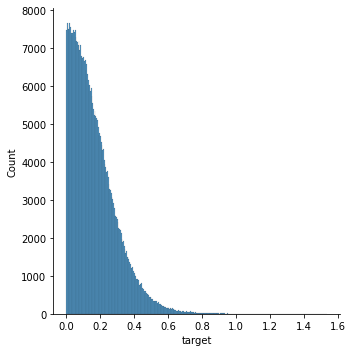

In [31]:
sns.displot(errors)

## Residuals time stamps

In [32]:
merged_train_df.iloc[errors_indices[-50:]]['row_id']

118207     33-27846
130775      37-4587
22166       5-25347
92299       27-3044
198035     58-22750
20218        5-8978
383344     113-3002
381258    112-17522
109326     31-17295
389          0-3135
334923     99-14452
231179     68-11792
3111        0-26107
136209     38-17949
18536       4-27003
277008     82-10779
301987     88-27511
239278     70-15194
1231        0-10450
69342       19-3318
215961     63-12552
204927     60-16192
300777     88-17117
152225     42-23972
269784     80-14243
302049     88-28020
198727     58-28881
77490       21-7251
329884      98-4377
147995     41-20439
184240      53-3399
204699     60-14326
389000    114-18147
37581       9-26107
397953    116-29676
77829      21-10448
22153       5-25277
256270     75-29842
256160     75-28745
80216      21-30805
377783    111-20439
26882         7-646
32708       8-17167
152318     42-24929
287878      85-5400
287760      85-4431
197132     58-15042
275261     81-28319
394991     116-4367
94401      27-20551


# Prepare submission

## Dataframe with target

In [33]:
test = pd.read_csv(path_prefix + 'test.csv')
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
test_stock_ids = test['stock_id'].unique()

## Dataframe with all features

In [34]:
test_main_df = preprocessor(test_stock_ids, is_train = False, is_parallel = False)

featurize_order_book, processing  ../input/optiver-realized-volatility-prediction/book_test.parquet/stock_id=0
featurize_trades, processing  ../input/optiver-realized-volatility-prediction/trade_test.parquet/stock_id=0


In [35]:
merged_test_df = test.merge(test_main_df, on = ['row_id'], how = 'left')
merged_test_df.head(10)

,stock_id,time_id,row_id,cross_wap_1_compute_normalized_diff,cross_wap_2_compute_normalized_diff,wap_1_compute_normalized_diff,wap_2_compute_normalized_diff,log_return_cross_wap_1_realized_volatility,log_return_cross_wap_1_std,log_return_cross_wap_2_realized_volatility,...,price_compute_normalized_diff_200,log_return_realized_volatility_200,log_return_std_200,seconds_in_bucket_count_unique_200,order_count_sum_200,price_compute_normalized_diff_100,log_return_realized_volatility_100,log_return_std_100,seconds_in_bucket_count_unique_100,order_count_sum_100
0,0,4,0-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extract feature matrix

In [36]:
test_row_id = merged_test_df['row_id']
X = merged_test_df[features]

## Prediction

In [38]:
y_pred = model_voting_prediction(X, models)

In [39]:
submission = pd.DataFrame({"row_id" : test_row_id, "target":y_pred}) 
submission.head()

,row_id,target
0,0-4,0.000576
1,0-32,0.000576
2,0-34,0.000576


In [40]:
submission.to_csv('submission.csv',index = False)